<a href="https://colab.research.google.com/github/vfrantc/covidpa/blob/main/eda_covid_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import expon

from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget https://raw.githubusercontent.com/vfrantc/covidpa/main/data.csv
!wget https://raw.githubusercontent.com/vfrantc/covidpa/main/out.csv


--2020-12-24 17:19:08--  https://raw.githubusercontent.com/vfrantc/covidpa/main/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5815168 (5.5M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   5.54M  28.6MB/s    in 0.2s    

2020-12-24 17:19:08 (28.6 MB/s) - ‘data.csv.1’ saved [5815168/5815168]

--2020-12-24 17:19:08--  https://raw.githubusercontent.com/vfrantc/covidpa/main/out.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9396914 (9.0M) [text/plain]
Saving to: ‘out.csv’

out.csv          

In [3]:
df = pd.read_csv('data.csv')
del df['Unnamed: 0']

In [4]:
df.head()

,ids,theta1,theta2,t,new_contagious,new_severe,new_dead
0,0,0.0,0,0,28,0,0
1,0,0.0,0,1,5,0,0
2,0,0.0,0,2,4,0,0
3,0,0.0,0,3,1,0,0
4,0,0.0,0,4,2,1,0


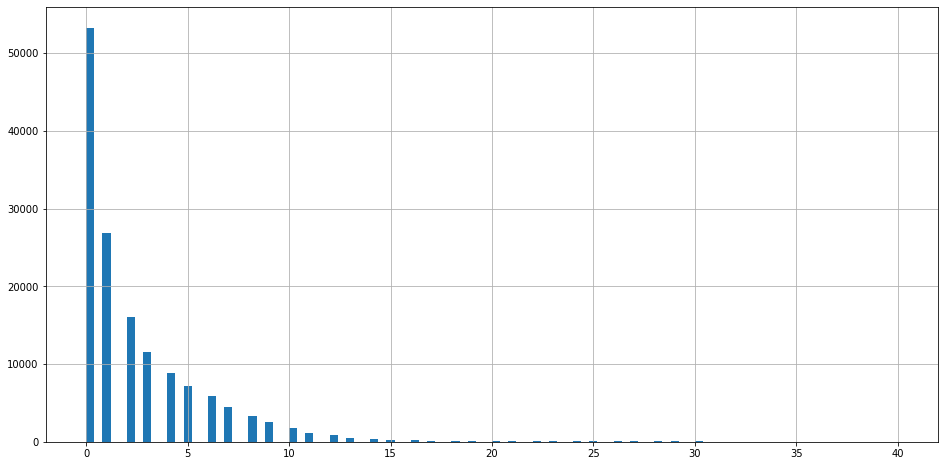

In [5]:
df.new_contagious.hist(bins=100, figsize=(16, 8))

In [6]:
# location and scale
expon.fit(df.new_contagious.ravel())

(0.0, 2.6011836578846887)

In [8]:
df2.head()

,Unnamed: 0,ids,theta1,theta2,t,new_contagious,new_severe,new_dead,new_recovered
0,0,0,0.0,0,0,18,0,0,0
1,1,0,0.0,0,1,1,0,0,0
2,2,0,0.0,0,2,3,0,0,0
3,3,0,0.0,0,3,3,0,0,0
4,4,0,0.0,0,4,3,0,0,1


In [9]:
df2 = pd.read_csv('out.csv')
del df2['Unnamed: 0']

In [12]:
stop_times = []
total_deads = []
total_recovereds = []
squared_things = []
things = []

hospital_capacity = 10
for myid, simulation in df2.groupby('ids'):
  new_severe = simulation['new_severe'].ravel()
  new_dead = simulation['new_dead'].ravel()
  new_recovered = simulation['new_recovered'].ravel()
  max_t = max(simulation['t'].ravel())

  stop_times.append(max_t)

  total_dead = sum(new_dead)
  total_deads.append(total_dead)

  total_recovered = sum(new_recovered)
  total_recovereds.append(total_recovered)

  thing = sum((hospital_capacity - (np.cumsum(new_severe) - np.cumsum(new_recovered))))
  things.append(thing)

  squared_thing = sum((hospital_capacity - (np.cumsum(new_severe) - np.cumsum(new_recovered)))**2)
  squared_things.append(squared_thing)

(array([ 23.,  44.,  42., 104., 152.,  81.,  93.,  74.,  76.,  85.,  60.,
         91.,  86.,  84., 106.,  83., 130., 126.,  95., 103., 118.,  87.,
        114.,  75.,  75.,  54.,  39.,  37.,  37.,  31.,  22.,  13.,  16.,
          8.,  12.,  10.,   3.,  11.,   6.,   3.,   3.,   3.,   1.,   2.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 15.  ,  19.62,  24.24,  28.86,  33.48,  38.1 ,  42.72,  47.34,
         51.96,  56.58,  61.2 ,  65.82,  70.44,  75.06,  79.68,  84.3 ,
         88.92,  93.54,  98.16, 102.78, 107.4 , 112.02, 116.64, 121.26,
        125.88, 130.5 , 135.12, 139.74, 144.36, 148.98, 153.6 , 158.22,
        162.84, 167.46, 172.08, 176.7 , 181.32, 185.94, 190.56, 195.18,
        199.8 , 204.42, 209.04, 213.66, 218.28, 222.9 , 227.52, 232.14,
        236.76, 241.38, 246.  ]),
 <a list of 50 Patch objects>)

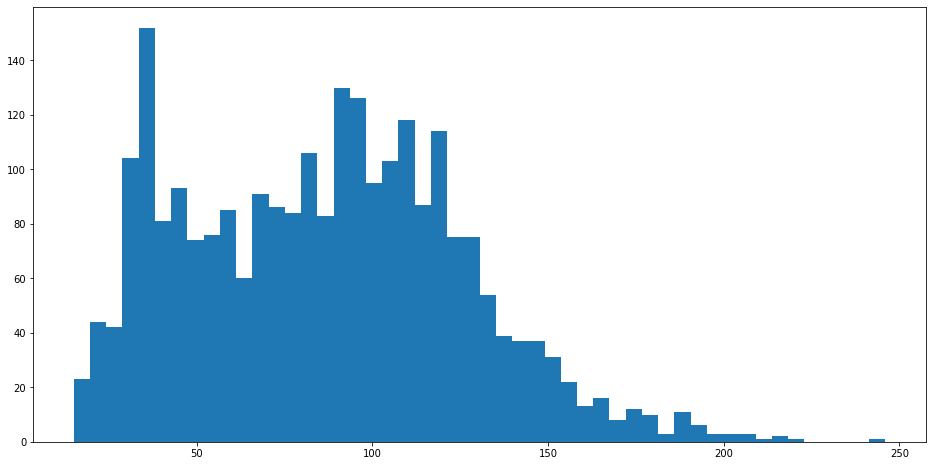

In [15]:
plt.figure(figsize=(16, 8))
plt.hist(stop_times, bins=50)

(array([  7.,  16.,  28.,  56.,  85., 114., 136.,   0., 126., 121., 126.,
        126., 112.,  95.,   0.,  90.,  99.,  88.,  86., 102.,  86.,   0.,
         86.,  86.,  89.,  66.,  58.,  67.,   0.,  51.,  57.,  58.,  40.,
         45.,  25.,   0.,  27.,  19.,  11.,  12.,   7.,   6.,   0.,   2.,
          2.,   3.,   2.,   0.,   1.,   1.]),
 array([ 1.  ,  1.86,  2.72,  3.58,  4.44,  5.3 ,  6.16,  7.02,  7.88,
         8.74,  9.6 , 10.46, 11.32, 12.18, 13.04, 13.9 , 14.76, 15.62,
        16.48, 17.34, 18.2 , 19.06, 19.92, 20.78, 21.64, 22.5 , 23.36,
        24.22, 25.08, 25.94, 26.8 , 27.66, 28.52, 29.38, 30.24, 31.1 ,
        31.96, 32.82, 33.68, 34.54, 35.4 , 36.26, 37.12, 37.98, 38.84,
        39.7 , 40.56, 41.42, 42.28, 43.14, 44.  ]),
 <a list of 50 Patch objects>)

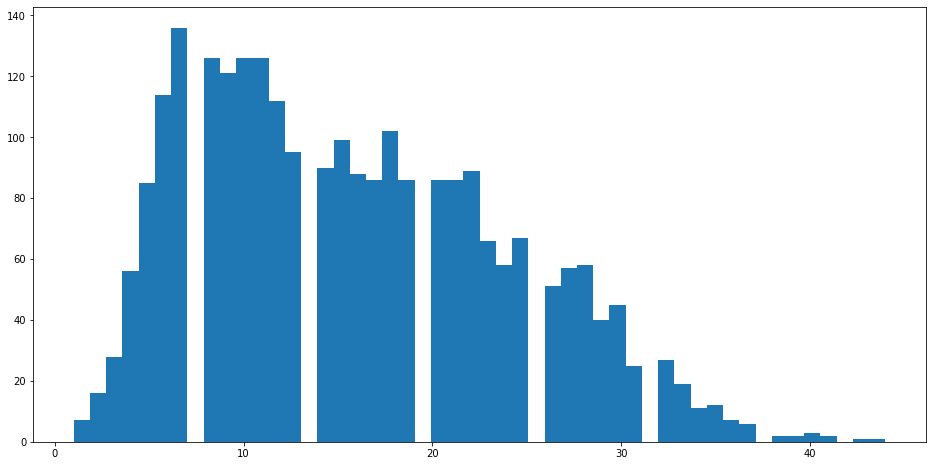

In [16]:
plt.figure(figsize=(16, 8))
plt.hist(total_deads, bins=50)

(array([ 24., 111., 179., 158., 126.,  84.,  88.,  59.,  63.,  57.,  62.,
         50.,  61.,  45.,  46.,  43.,  60.,  35.,  48.,  47.,  35.,  43.,
         43.,  36.,  36.,  40.,  37.,  34.,  36.,  33.,  36.,  49.,  35.,
         50.,  37.,  41.,  46.,  53.,  33.,  37.,  51.,  59.,  34.,  41.,
         33.,  39.,  11.,   8.,   5.,   3.]),
 array([  9.  ,  16.16,  23.32,  30.48,  37.64,  44.8 ,  51.96,  59.12,
         66.28,  73.44,  80.6 ,  87.76,  94.92, 102.08, 109.24, 116.4 ,
        123.56, 130.72, 137.88, 145.04, 152.2 , 159.36, 166.52, 173.68,
        180.84, 188.  , 195.16, 202.32, 209.48, 216.64, 223.8 , 230.96,
        238.12, 245.28, 252.44, 259.6 , 266.76, 273.92, 281.08, 288.24,
        295.4 , 302.56, 309.72, 316.88, 324.04, 331.2 , 338.36, 345.52,
        352.68, 359.84, 367.  ]),
 <a list of 50 Patch objects>)

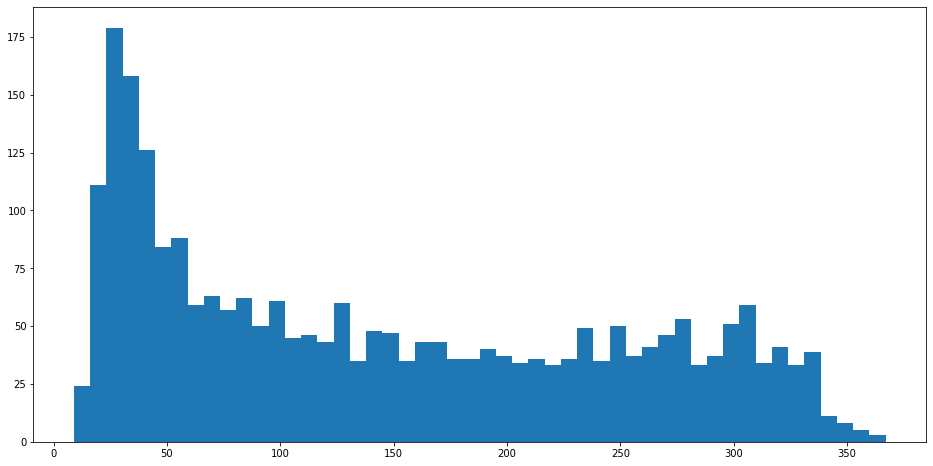

In [17]:
plt.figure(figsize=(16, 8))
plt.hist(total_recovereds, bins=50)

(array([ 13.,  77., 130., 166., 142., 107.,  88.,  63.,  64.,  59.,  63.,
         57.,  53.,  53.,  41.,  43.,  53.,  49.,  43.,  38.,  47.,  42.,
         44.,  36.,  43.,  38.,  29.,  39.,  39.,  32.,  45.,  39.,  31.,
         46.,  39.,  42.,  40.,  45.,  44.,  31.,  47.,  56.,  49.,  42.,
         37.,  42.,  28.,  10.,  11.,   5.]),
 array([ 11. ,  18.6,  26.2,  33.8,  41.4,  49. ,  56.6,  64.2,  71.8,
         79.4,  87. ,  94.6, 102.2, 109.8, 117.4, 125. , 132.6, 140.2,
        147.8, 155.4, 163. , 170.6, 178.2, 185.8, 193.4, 201. , 208.6,
        216.2, 223.8, 231.4, 239. , 246.6, 254.2, 261.8, 269.4, 277. ,
        284.6, 292.2, 299.8, 307.4, 315. , 322.6, 330.2, 337.8, 345.4,
        353. , 360.6, 368.2, 375.8, 383.4, 391. ]),
 <a list of 50 Patch objects>)

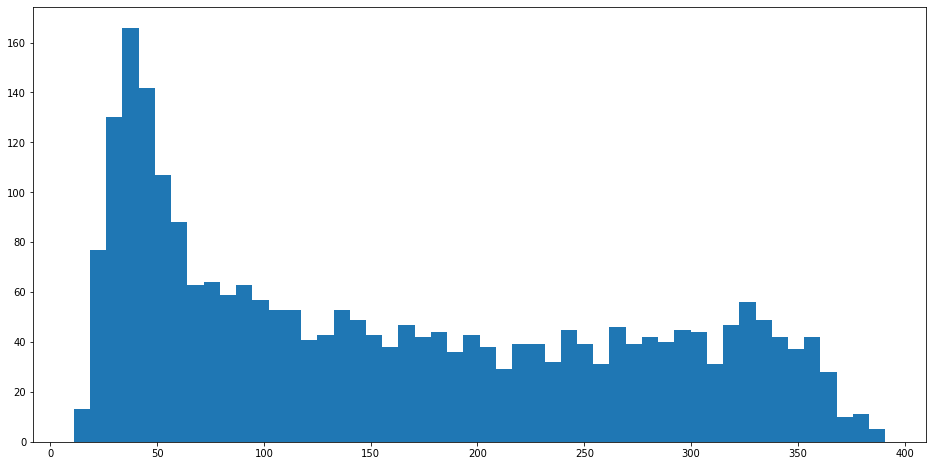

In [20]:
plt.figure(figsize=(16, 8))
plt.hist(np.array(total_recovereds) + np.array(total_deads), bins=50)

(array([995., 226., 147.,  96.,  94.,  94.,  72.,  59.,  53.,  69.,  54.,
         65.,  57.,  60.,  59.,  33.,  43.,  36.,  26.,  25.,  29.,  23.,
         28.,   9.,  13.,   7.,   7.,   5.,  12.,   3.,   7.,   4.,   0.,
          0.,   2.,   1.,   0.,   1.,   1.,   2.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.]),
 array([2.35600000e+03, 2.93897700e+05, 5.85439400e+05, 8.76981100e+05,
        1.16852280e+06, 1.46006450e+06, 1.75160620e+06, 2.04314790e+06,
        2.33468960e+06, 2.62623130e+06, 2.91777300e+06, 3.20931470e+06,
        3.50085640e+06, 3.79239810e+06, 4.08393980e+06, 4.37548150e+06,
        4.66702320e+06, 4.95856490e+06, 5.25010660e+06, 5.54164830e+06,
        5.83319000e+06, 6.12473170e+06, 6.41627340e+06, 6.70781510e+06,
        6.99935680e+06, 7.29089850e+06, 7.58244020e+06, 7.87398190e+06,
        8.16552360e+06, 8.45706530e+06, 8.74860700e+06, 9.04014870e+06,
        9.33169040e+06, 9.62323210e+06, 9.91477380e+06, 1.02063155e+07,
        1.

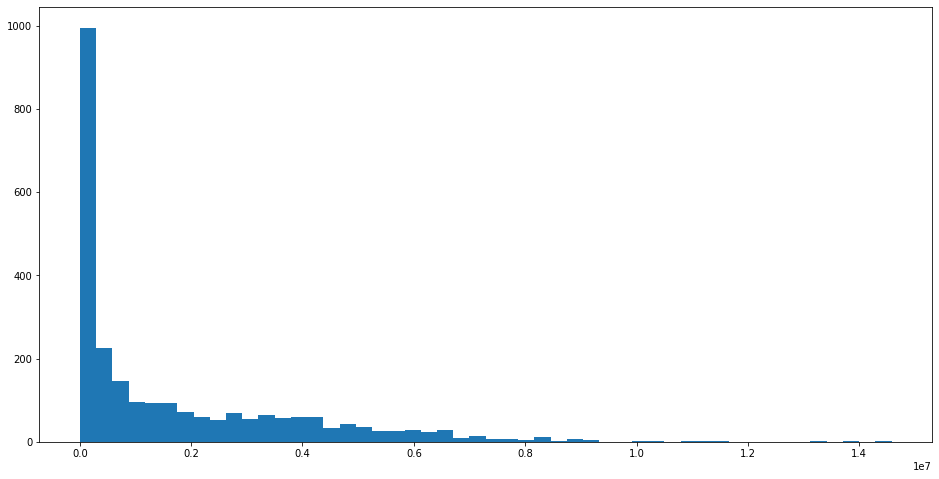

In [18]:
plt.figure(figsize=(16, 8))
plt.hist(squared_things, bins=50)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


KeyboardInterrupt: ignored

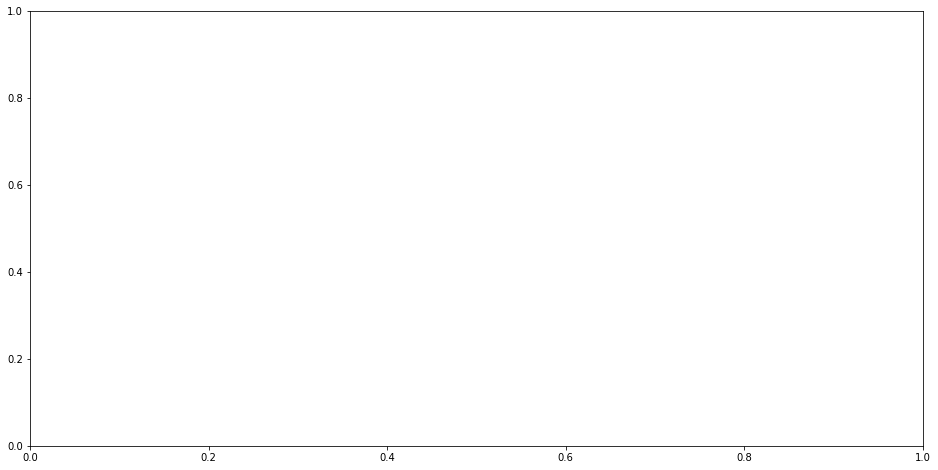

In [19]:
plt.figure(figsize=(16, 8))
plt.hist(things, bins=50)

In [11]:
x = [1, 2, 3, 5, 6]

In [13]:
sum((hospital_capacity - (np.cumsum(new_severe) - np.cumsum(new_recovered)))**2)

array([0, 0, 0, 0, 0])

In [7]:
X = []
y = []

In [8]:
win_size = 14
for myid, simulation in df.groupby('ids'):
  new_contagious = simulation['new_contagious'].ravel()
  new_severe = simulation['new_severe'].ravel()
  new_contagious = np.pad(new_contagious, pad_width=(win_size-1, 0))
  for i in range(len(new_severe)):
    y.append(new_severe[i])
    X.append(new_contagious[i:(i+win_size)])

In [9]:
X[0], y[0]

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 28]), 0)

In [10]:
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))



Linear: 0.222 ([0.22263796 0.22813984 0.21652952 0.22594633 0.2155118 ])
Ridge: 0.222 ([0.22843159 0.22782271 0.22329183 0.21255668 0.21611084])
Lasso: -0.000 ([-1.67042316e-05 -9.99561118e-07 -4.41684569e-05 -3.69137035e-05
 -6.06929187e-05])
Elastic: 0.135 ([0.13550601 0.13245634 0.13648897 0.13438202 0.13489772])


In [ ]:
model = LinearRegression().fit(X, y)

In [ ]:
model.coef_

array([-1.33954944e-03,  8.92882299e-05,  4.02847485e-03,  4.03902919e-03,
        6.36561104e-03,  8.43052820e-03,  1.13886113e-02,  1.60833137e-02,
        1.95132551e-02,  2.67180288e-02,  1.67092903e-03,  2.66874629e-03,
        3.20820041e-03,  3.54900713e-03])

In [ ]:
model.intercept_

0.0022841226785017543

In [ ]:
poly = PolynomialFeatures(2)
X_ = poly.fit_transform(X)
models = []
models.append(('Linear', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('Elastic', ElasticNet()))

# evaluate each model in turn
for name, model in models:
    cv_results = cross_val_score(model, X_, y, cv=KFold(n_splits=5, shuffle=True), scoring='r2')
    print("{}: {:.3f} ({})".format(name, cv_results.mean(), cv_results))

Linear: 0.252 ([0.25478124 0.24483665 0.25409194 0.25164098 0.25292471])
Ridge: 0.252 ([0.253268   0.25606892 0.24771679 0.25707679 0.24370698])
Lasso: 0.223 ([0.21520951 0.22125306 0.2225676  0.23494108 0.22276434])
Elastic: 0.227 ([0.23081374 0.22146772 0.22111681 0.22709877 0.2336273 ])


In [ ]:
model = LinearRegression().fit(X_, y)

In [ ]:
model.coef_

array([ 9.03008077e-19, -2.13479392e-03,  7.57963895e-04,  5.92652328e-03,
        5.36240411e-03,  6.69832542e-03,  7.85889285e-03,  1.28709239e-02,
        1.11141110e-02,  1.61972703e-02,  1.88358039e-02,  5.26370756e-03,
        6.74641795e-03,  3.48855305e-03, -1.02181847e-04,  1.12591270e-03,
       -4.50001708e-04, -1.98935081e-04, -6.96081972e-04,  6.10131827e-06,
       -8.22753722e-05,  7.77975032e-05, -3.87614013e-04,  4.08387525e-04,
       -8.05198117e-06, -1.69493942e-04, -5.91011109e-05, -2.71535504e-04,
       -5.52336447e-05,  1.05968467e-03, -3.81053002e-04, -7.43304947e-05,
       -3.91863041e-04, -4.29091980e-04,  3.07421406e-04, -4.79581543e-05,
       -8.41989263e-04, -2.29569579e-04, -5.15327846e-04,  1.80602097e-04,
        2.05952900e-04, -3.11005517e-04,  6.18022297e-04, -6.29924708e-04,
       -2.92367645e-04, -3.09378515e-04, -1.91105041e-04,  1.23929943e-04,
       -1.76655865e-05, -2.43428397e-04,  1.56039817e-04,  1.10056042e-04,
        3.58746977e-04, -

In [ ]:
model.intercept_

-0.0029794670492998554